In [14]:
import csv
import pandas as pd
import datetime as datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import dateutil.parser
import re
import pytz
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [15]:
# Load the data

# Load the actual values from the automatic weather observation system (SMN) in Zollikofen. 
df_smn = pd.read_csv('data/smn.csv')

# Load the values from the 5 day weather forecast.

# Meteo Schweiz
df_meteoschweiz = pd.read_csv('data/meteoschweiz.csv')
df_meteoschweiz_symbs = pd.read_csv('data/meteoschweiz_symb.csv')

# SRF Meteo
df_srf = pd.read_csv('data/srf.csv')

# Meteotest
df_meteotest = pd.read_csv('data/meteotest.csv')

# Meteonews
df_meteonews = pd.read_csv('data/meteonews.csv')

In [16]:
df_smn.tail()

,code,dateTime,gustPeak,humidity,windSpeed,windDirection,qnhPressure,temperature,precipitation,sunshine,qfePressure,qffPressure
5050,BER,2016-09-08T19:40:00.000Z,4.0,77,2.5,122,1017.7,19.0,0,0,952.6,1015.7
5051,BER,2016-09-08T19:50:00.000Z,3.6,78,2.5,166,1017.7,18.9,0,0,952.6,1015.7
5052,BER,2016-09-08T20:00:00.000Z,2.9,83,0.7,205,1017.7,17.8,0,0,952.6,1015.9
5053,BER,2016-09-08T20:10:00.000Z,3.6,80,1.8,107,1017.8,18.4,0,0,952.7,1015.9
5054,BER,2016-09-08T20:20:00.000Z,2.2,82,0.7,221,1017.8,17.8,0,0,952.7,1016.0


In [17]:
# Preprocess the data. 

# Convert the time column to index (time series) 
def parse_date(str_date):
    temp = dateutil.parser.parse(str_date)
    try:
        return pytz.utc.localize(temp)
    except ValueError: 
        return temp

def drop_degree(str_deg):
    temp = re.search(r'\d+',str_deg)
    return float(temp.group(0))

# SMN
df_smn['time'] = df_smn['dateTime'].apply(parse_date)
df_smn.index = df_smn['time']
df_smn = df_smn.drop('time',axis=1)
df_smn = df_smn.drop('dateTime',axis=1)

# Meteonews
df_meteonews['time'] = df_meteonews['time'].apply(parse_date)
df_meteonews.index = df_meteonews['time']
df_meteonews = df_meteonews.drop('time',axis=1)

# SRF
df_srf['time'] = df_srf['time'].apply(parse_date)
df_srf.index = df_srf['time']
df_srf = df_srf.drop('time',axis=1)
df_srf['temp'] = df_srf['temp'].apply(drop_degree)

# Meteotest
df_meteotest['date'] = df_meteotest['date'].apply(parse_date)
df_meteotest.index = df_meteotest['date']
df_meteotest = df_meteotest.drop('date',axis=1)

# Meteo Schweiz
df_meteoschweiz.columns = ['time','temp','rain']
df_meteoschweiz['time'] = df_meteoschweiz['time'].apply(parse_date)
df_meteoschweiz.index = df_meteoschweiz['time']
df_meteoschweiz = df_meteoschweiz.drop('time',axis=1)

df_meteoschweiz_symbs.columns = ['time','symb']
df_meteoschweiz_symbs['time'] = df_meteoschweiz_symbs['time'].apply(parse_date)
df_meteoschweiz_symbs.index = df_meteoschweiz_symbs['time']
df_meteoschweiz_symbs = df_meteoschweiz_symbs.drop('time',axis=1)

In [18]:
# Merge the datasets

# SMN and Meteonews
df = pd.merge(df_smn, df_meteonews, right_index=True, left_index=True, how='outer')
df = df[['temperature','temp']]
df.columns = ['temp_smn','temp_meteonews']

# Adding Meteotest
df = pd.merge(df, df_meteotest, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest']

# Adding MeteoSchweiz
df = pd.merge(df, df_meteoschweiz, right_index=True, left_index=True, how='outer') # Why??
df = df[['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp']]
df.columns = ['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp_meteoschweiz']

# Adding SRF
df = pd.merge(df, df_srf, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp_srf']

In [19]:
df.count()

temp_smn             5127
temp_meteonews        299
temp_meteotest        872
temp_meteoschweiz     650
temp_srf              286
dtype: int64

## Graphs

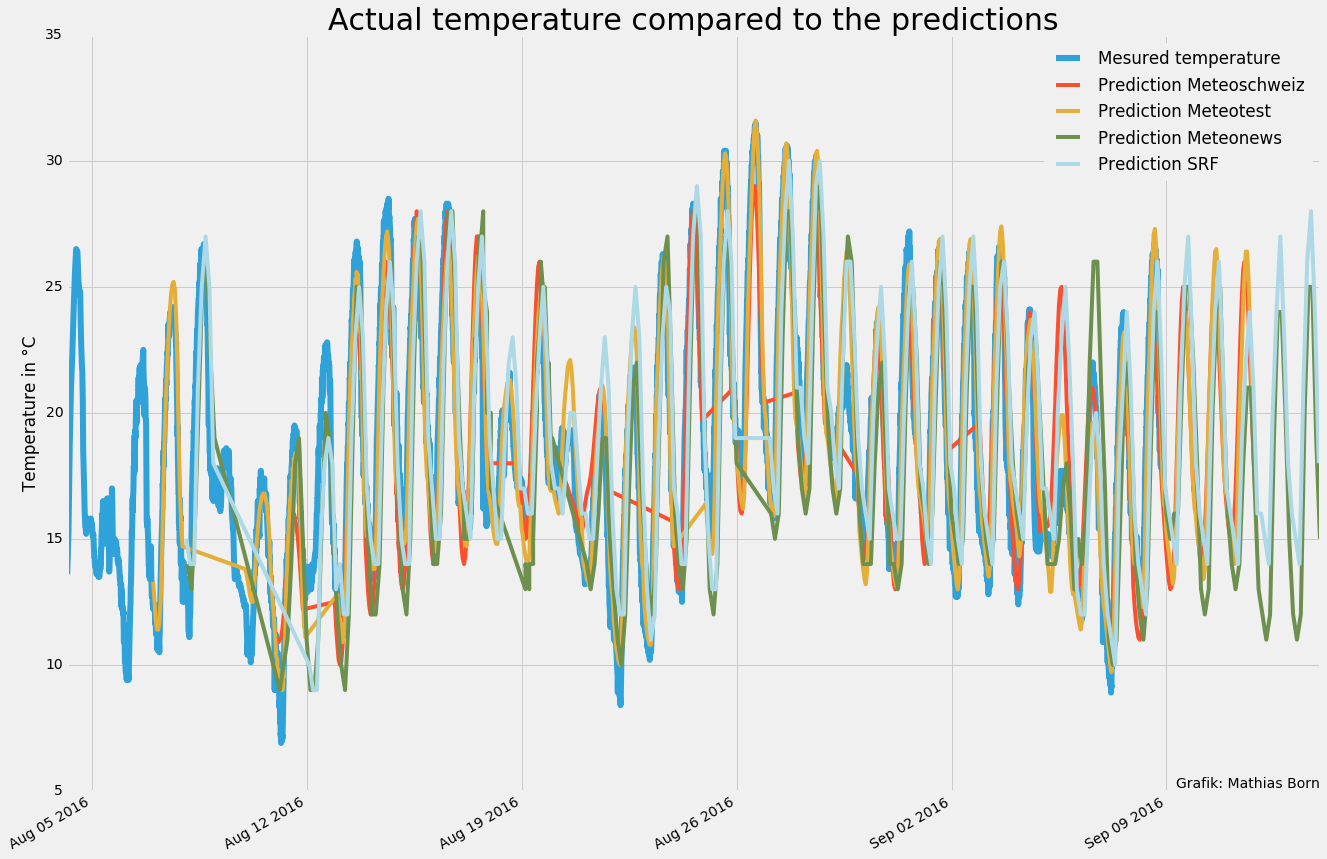

In [20]:
# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(20,15))

# Pass the ax to the .plot function
df['temp_smn'].dropna().plot(kind='line', label='Mesured temperature', legend=True, linewidth=6, ax=ax)
df['temp_meteoschweiz'].dropna().plot(kind='line', label='Prediction Meteoschweiz', legend=True, ax=ax)
df['temp_meteotest'].dropna().plot(kind='line', label='Prediction Meteotest', legend=True, ax=ax)
df['temp_meteonews'].dropna().plot(kind='line', label='Prediction Meteonews', legend=True, ax=ax)
df['temp_srf'].dropna().plot(kind='line', label='Prediction SRF', color='lightblue', legend=True, ax=ax)

ax.set_ylabel("Temperature in °C")
ax.set_title("Actual temperature compared to the predictions", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/temperature.png')

## Calculate offset

In [21]:
# Calculating the offset in degrees.

df['temp_offset_meteonews'] = df['temp_smn'] - df['temp_meteonews']
df['temp_offset_meteotest'] = df['temp_smn'] - df['temp_meteotest']
df['temp_offset_meteoschweiz'] = df['temp_smn'] - df['temp_meteoschweiz']
df['temp_offset_srf'] = df['temp_smn'] - df['temp_srf']

In [22]:
# Calculating the offset in percent.

df['temp_offset_meteonews_percent'] = abs(100 * df['temp_offset_meteonews'] / df['temp_smn'])
df['temp_offset_meteotest_percent'] = abs(100 * df['temp_offset_meteotest'] / df['temp_smn'])
df['temp_offset_meteoschweiz_percent'] = abs(100 * df['temp_offset_meteoschweiz'] / df['temp_smn'])
df['temp_offset_srf'] = abs(100 * df['temp_offset_srf'] / df['temp_smn'])

In [23]:
df[['temp_offset_meteonews_percent','temp_offset_meteotest_percent', 'temp_offset_meteoschweiz_percent', 'temp_offset_srf']].describe()

,temp_offset_meteonews_percent,temp_offset_meteotest_percent,temp_offset_meteoschweiz_percent,temp_offset_srf
count,224.000000,777.000000,563.000000,240.000000
mean,15.917107,6.492058,9.795569,14.255532
std,12.081181,5.573668,8.758291,11.174968
min,0.000000,0.000000,0.000000,0.000000
25%,6.792003,2.531646,3.374990,5.224741
50%,14.285714,5.288462,7.878788,12.011002
75%,22.286822,8.910891,13.333333,20.922499
max,72.839506,44.444444,60.869565,52.866242


In [24]:
time1 = str(datetime.datetime.now() - timedelta(days=14))
time2 = str(datetime.datetime.now())
df[time1:time2][['temp_offset_meteonews','temp_offset_meteotest', 'temp_offset_meteoschweiz', 'temp_offset_srf']].resample('2H').mean()

temp_offset_meteonews        0.400000
temp_offset_meteotest       -0.111290
temp_offset_meteoschweiz    -0.021944
temp_offset_srf             15.152900
dtype: float64

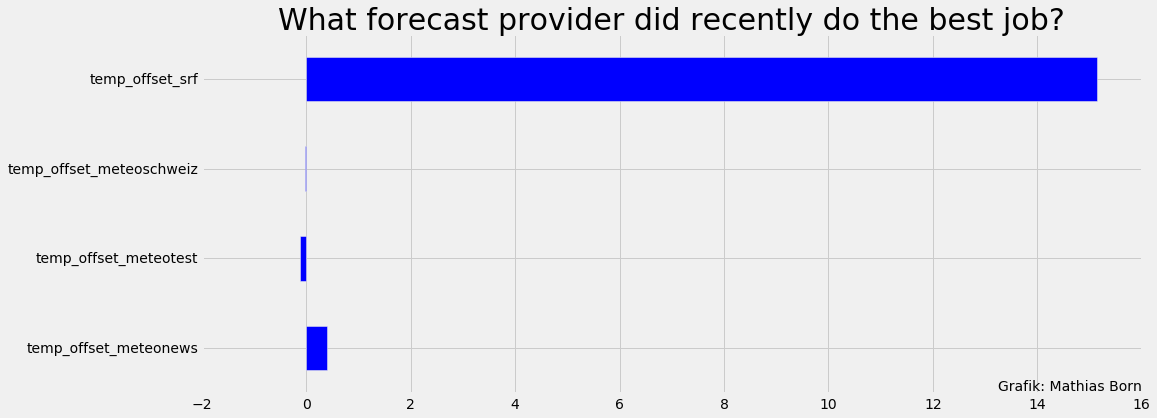

In [26]:
time1 = str(datetime.datetime.now() - timedelta(days=14))
time2 = str(datetime.datetime.now())

# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(15,6))

# Pass the ax to the .plot function
df[time1:time2][['temp_offset_meteonews','temp_offset_meteotest', 'temp_offset_meteoschweiz', 'temp_offset_srf']].resample('3H').mean().plot(ax=ax, kind='barh') #label=['Offset Meteonews', 'Offset Meteotest', 'Offset Meteoschweiz', 'Offset SRF']
ax.set_title("What forecast provider did recently do the best job?", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/offset.png')